### Bot Detection using Digital DNA Compression

## Modifications by TS
Here, the original MIB-1 dataset is still used to train the classifier. The Twibot-20 testdataset is used to evaulte this classifier. This is done for both mixed1 and mixed2.
### The following error occurred when running the script 
```
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf3 in position 204140: invalid continuation byte
```
### Solution
Added:
`, encoding='latin-1'`

## Same error for other CSVs
Changed encoding to `latin-1` because it has no influence on the outcome (digital DNA is content independent).

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [17]:
import random
import sys
import time
import zlib

In [18]:
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
from scipy.stats import ttest_1samp

<hr>

### Digital DNA

Model account behaviour by defining the following alphabet, of cardinality N = 3,

$B^3_{type} = {\{A, C, T\}}$

A $\leftarrow$ tweet,

C $\leftarrow$ reply,

T $\leftarrow$ retweet

<hr>

#### Datasets

User profile data.

In [19]:
### Users

# Genuine accounts.
gen = pd.read_csv('./datasets_full/datasets_full.csv/genuine_accounts.csv/users.csv')

# Social spambots.
ss1 = pd.read_csv('./datasets_full/datasets_full.csv/social_spambots_1.csv/users.csv')
ss2 = pd.read_csv('./datasets_full/datasets_full.csv/social_spambots_2.csv/users.csv')
ss3 = pd.read_csv('./datasets_full/datasets_full.csv/social_spambots_3.csv/users.csv')

# Traditional spambots.
ts1 = pd.read_csv('./datasets_full/datasets_full.csv/traditional_spambots_1.csv/users.csv')
ts2 = pd.read_csv('./datasets_full/datasets_full.csv/traditional_spambots_2.csv/users.csv')
ts3 = pd.read_csv('./datasets_full/datasets_full.csv/traditional_spambots_3.csv/users.csv')
ts4 = pd.read_csv('./datasets_full/datasets_full.csv/traditional_spambots_4.csv/users.csv')


# Genuine accounts.
gen_test = pd.read_csv('./Twibot-20/twibot_testset_accountdata_genuineuser.csv')

# Bot accounts.
bot_test = pd.read_csv('./Twibot-20/twibot_testset_accountdata_botuser.csv')

Tweets.

In [20]:
### Tweets

# Genuine accounts.
gen_tweets = pd.read_csv('./datasets_full/datasets_full.csv/genuine_accounts.csv/tweets.csv', encoding='latin-1')

# Social spambots.
ss1_tweets = pd.read_csv('./datasets_full/datasets_full.csv/social_spambots_1.csv/tweets.csv', encoding='latin-1')
ss2_tweets = pd.read_csv('./datasets_full/datasets_full.csv/social_spambots_2.csv/tweets.csv', encoding='latin-1')
ss3_tweets = pd.read_csv('./datasets_full/datasets_full.csv/social_spambots_3.csv/tweets.csv', encoding='latin-1')

# Traditional spambots.
ts1_tweets = pd.read_csv('./datasets_full/datasets_full.csv/traditional_spambots_1.csv/tweets.csv', encoding='latin-1')

# Genuine accounts.
gen_test_tweets = pd.read_csv('./Twibot-20/twibot_testset_tweetdata_genuineuser.csv')


# Bot accounts.
bot_test_tweets = pd.read_csv('./Twibot-20/twibot_testset_tweetdata_botuser.csv')

<hr>

#### Digital DNA.

In [21]:
def create_dna_from_tweets(tweets_df):
    '''For each user id in tweets_df return a digital DNA string based on posting behaviour.'''
    
    # Add columns for counts of tweets, replies and retweets.
    tweets_df['num_retweets'] = np.where(tweets_df['retweeted_status_id'] == 0, 0, 1)
    tweets_df['num_replies'] = np.where(tweets_df['in_reply_to_status_id'] == 0, 0, 1)
    tweets_df['num_tweets'] = np.where((tweets_df['num_retweets'] == 0) & (tweets_df['num_replies'] == 0), 1, 0)

    # DNA alphabet for tweet (A), retweet (C) and reply (T).
    tweets = tweets_df['num_tweets'] == 1
    retweets = tweets_df['num_retweets'] == 1
    replies = tweets_df['num_replies'] == 1

    tweets_df.loc[:, 'DNA'] = np.where(retweets, 'C', np.where(replies, 'T', 'A'))

    # Sort tweets by timestamp..
    tweets_df = tweets_df[['user_id', 'timestamp', 'DNA']]
    tweets_df = tweets_df.sort_values(by=['timestamp'])

    # Create digital DNA string for each user account.
    dna = tweets_df.groupby(by=['user_id'])['DNA'].agg(lambda x: ''.join(x))
    
    return dna

In [22]:
def compress_dna_df(dna):
    '''Return a dataframe with compression facts for a series of dna.'''

    # Convert DNA in string object to bytes object.
    dna_bytes = dna.apply(lambda s: s.encode('utf-8'))

    # Run compression on each DNA string in the sample.
    dna_compressed = dna_bytes.apply(lambda b: zlib.compress(b))

    # Create dataframe with compression facts.
    dna_df = pd.DataFrame({'dna': dna,
                           'original_dna_size': dna_bytes.apply(sys.getsizeof), 
                           'compressed_dna_size': dna_compressed.apply(sys.getsizeof)})
    
    dna_df['compression_ratio'] = dna_df['original_dna_size'] / dna_df['compressed_dna_size']
    
    return dna_df

<hr>

Create DNA strings based on behaviour activity for each account.

In [23]:
gen_dna = create_dna_from_tweets(gen_tweets)

ss1_dna = create_dna_from_tweets(ss1_tweets)
ss2_dna = create_dna_from_tweets(ss2_tweets)
ss3_dna = create_dna_from_tweets(ss3_tweets)

ts1_dna = create_dna_from_tweets(ts1_tweets)


gen_test_dna = create_dna_from_tweets(gen_test_tweets)

bot_test_dna = create_dna_from_tweets(bot_test_tweets)

Compression on digital DNA strings.

In [24]:
gen_dna = compress_dna_df(gen_dna)

ss1_dna = compress_dna_df(ss1_dna)
ss2_dna = compress_dna_df(ss2_dna)
ss3_dna = compress_dna_df(ss3_dna)

ts1_dna = compress_dna_df(ts1_dna)

bot_dna = pd.concat([ss1_dna, ss2_dna, ss3_dna])


gen_test_dna = compress_dna_df(gen_test_dna)

bot_test_dna = compress_dna_df(bot_test_dna)

In [25]:
# Add a column for label to the dataframes.
gen_test_dna['label'] = 0

bot_test_dna['label'] = 1

In [26]:
# For bot_test accounts without tweets, generate according dna
bot_test_with_no_tweets = bot_test[~bot_test['id'].isin(bot_test_dna.index)]

bot_test_with_no_tweets_dna = pd.DataFrame({'id': bot_test_with_no_tweets['id'], 
                                             'original_dna_size': 33, 
                                             'compressed_dna_size': 41, 
                                             'compression_ratio': 0.80, 
                                             'label': 1})

bot_test_with_no_tweets_dna = bot_test_with_no_tweets_dna.set_index('id')

bot_test_dna = pd.concat([bot_test_dna, bot_test_with_no_tweets_dna])

# For gen_test accounts without tweets, generate according dna
gen_test_with_no_tweets = gen_test[~gen_test['id'].isin(gen_test_dna.index)]

gen_test_with_no_tweets_dna = pd.DataFrame({'id': gen_test_with_no_tweets['id'], 
                                             'original_dna_size': 33, 
                                             'compressed_dna_size': 41, 
                                             'compression_ratio': 0.80, 
                                             'label': 0})

gen_test_with_no_tweets_dna = gen_test_with_no_tweets_dna.set_index('id')

gen_test_dna = pd.concat([gen_test_dna, gen_test_with_no_tweets_dna])


In [27]:
test_dna = pd.concat([gen_test_dna, bot_test_dna])

<hr>

#### Visualise compression facts for accounts.

In [28]:
# Add a column for account type to the dataframes.
gen_dna['Account Type'] = 'Genuine'
bot_dna['Account Type'] = 'Bot'

# Combine all samples into a single dataframe.
all_dna = pd.concat([gen_dna, bot_dna])

In [29]:
all_dna.sample(5)

dna  \
user_id                                                           
2.387040e+09  AAAAAAATAATAATTAATAATTAATAATATAATAATATAATAATAA...   
2.384764e+09  AAAAAAAAAATAAAATAATAATAATTAATAATTATATATAATATAT...   
1.982490e+08  TTTATTAACCCAATATACTTATTTTCTTAAACTTAATATAAACCAA...   
5.312413e+08  AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...   
2.374438e+09  AAAATAATAATAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATA...   

              original_dna_size  compressed_dna_size  compression_ratio  \
user_id                                                                   
2.387040e+09                123                   60           2.050000   
2.384764e+09                115                   62           1.854839   
1.982490e+08               3254                  881           3.693530   
5.312413e+08               3264                   60          54.400000   
2.374438e+09                120                   59           2.033898   

             Account Type  
user_id                    
2.387040e+09          Bot  
2.384764e+09          Bot  
1.982490e+08      Genuine  
5.312413e+08          Bot  
2.374438e+09          Bot

##### Plot of Uncompressed DNA Size vs. Compressed DNA Size.

Includes the following accounts:
1. Genuine users
1. Social Spambots \#1
1. Social Spambots \#2
1. Social Spambots \#3
1. Traditional Spambots \#1

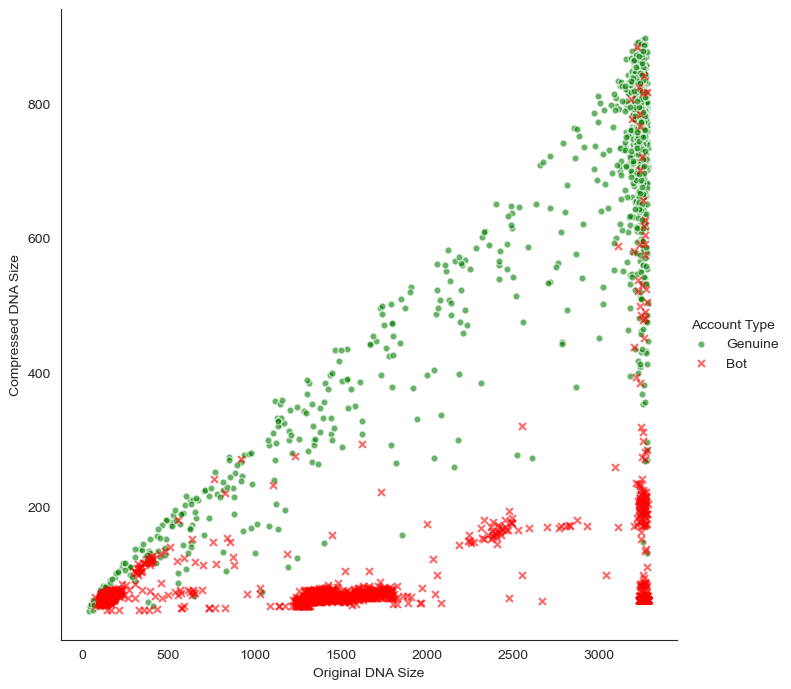

In [30]:
sns.set_style("white")

pal = {
    'Genuine': 'green',
    'Bot': 'red'
}

g = sns.FacetGrid(all_dna, hue='Account Type', palette=pal, size=7, hue_kws=dict(marker=["o", "x"]))
g.map(plt.scatter, "original_dna_size", "compressed_dna_size", s=25, alpha=.6, edgecolor="white")
g.add_legend()
g.set_axis_labels('Original DNA Size', 'Compressed DNA Size')

##### Plot of DNA Size vs. Compression Ratio.

Includes the following accounts:
1. Genuine users
1. Social Spambots \#1
1. Social Spambots \#2
1. Social Spambots \#3
1. Traditional Spambots \#1

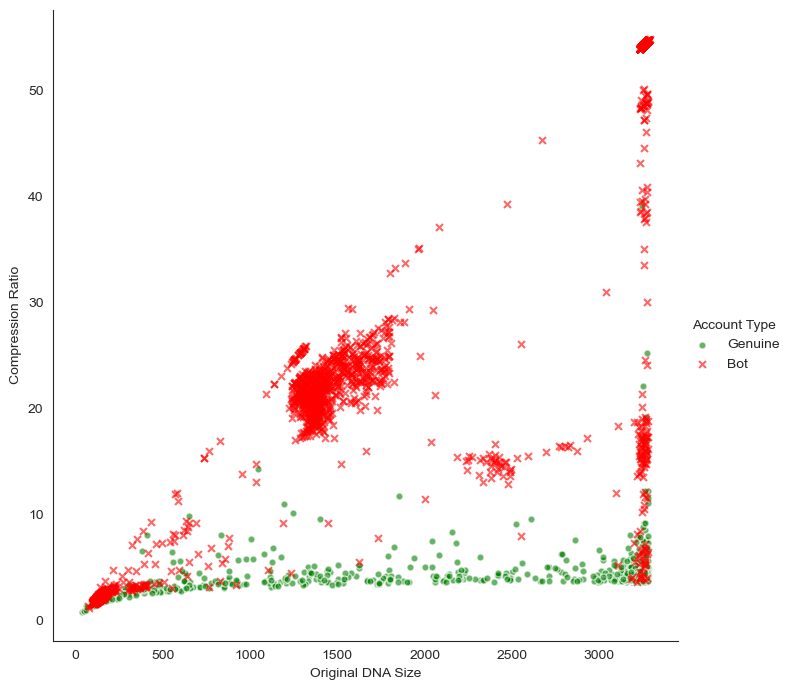

In [31]:
sns.set_style("white")

pal = {
    'Genuine': 'green',
    'Bot': 'red'
}

g = sns.FacetGrid(all_dna, hue='Account Type', palette=pal, size=7, hue_kws=dict(marker=["o", "x"]))
g.map(plt.scatter, "original_dna_size", "compression_ratio", s=25, alpha=.6, edgecolor="white")
g.add_legend()
g.set_axis_labels('Original DNA Size', 'Compression Ratio')

##### Historgram for Compression Ratio

Includes the following accounts:
1. Genuine users
1. Social Spambots \#1
1. Social Spambots \#2
1. Social Spambots \#3
1. Traditional Spambots \#1

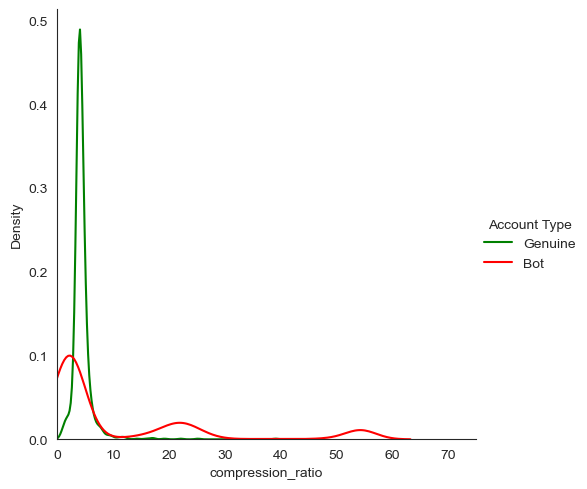

In [32]:
g = sns.FacetGrid(all_dna, hue='Account Type', palette=pal, size=5)
g.set(xlim=(0, 75))
g.map(sns.kdeplot, 'compression_ratio')
g.add_legend()

<hr>

Evaluation Metrics
1. Accuracy
1. Precision
1. Recall
1. F1 Score
1. Specificity
1. MCC

In [33]:
def evaluate(y_test, predictions):
    '''Return a dataframe with accuracy, precision, recall and f1 scores for predictions.'''
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    specificity = tn / (tn+fp)
    
    results = [
        {
            'Metric': 'Accuracy',
            'Score': accuracy_score(y_test, predictions)
        },
        {
            'Metric': 'Precision',
            'Score': precision_score(y_test, predictions)
        },
        {
            'Metric': 'Recall',
            'Score': recall_score(y_test, predictions)
        },
        {
            'Metric': 'F1 Score',
            'Score': f1_score(y_test, predictions)
        },
        {
            'Metric': 'MCC',
            'Score': matthews_corrcoef(y_test, predictions)
        },
        {
            'Metric': 'Specificity',
            'Score': specificity
        },
    ]

    return pd.DataFrame(results)

<hr>

In [34]:
def train_predict_evaluate(dna, features, test_size=0.5):
    '''Train a Logistic Regression model with given features
    using default parameters on a random sample of data.'''

    # Randomly shuffle the dna dataframe.
    dna = utils.shuffle(dna)

    # Features and labels.
    X = dna[features]
    # ANMERKUNG TS: Es wird also auf das label zugegriffen, wo später steht, ob es genuine oder bot ist
    y = dna.loc[:, 'label']

    # Split the dataset for training and testing using Logistic Regression.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    X_test = test_dna[features]
    y_test = test_dna.loc[:, 'label']
    
    # Logistic Regression classifier with default parameters.
    classifier = LogisticRegression()

    # Train the classifier.
    start_train = time.time()
    classifier.fit(X_train, y_train)
    end_train = time.time()

    # Make predictions on the test set.
    start_test = time.time()
    predictions = classifier.predict(X_test)

    
    end_test = time.time()
    
    
    # Evaluation on the test set.
    results = evaluate(y_test, predictions)

    return results

<hr>

Results for k-common substring

In [35]:
k_common_substring_1 = pd.DataFrame({'Supervised': [0.977, 0.977, 0.955, 0.982, 0.977, 0.981],
                                     'Unsupervised': [0.976, 0.977, 0.952, 0.982, 0.972, 0.981]}, 
                                    index=['Accuracy', 'F1 Score', 'MCC', 'Precision', 'Recall', 'Specificity'])


In [36]:
k_common_substring_2 = pd.DataFrame({'Supervised': [0.970, 0.970, 0.940, 0.978, 0.961, 0.979], 
                                     'Unsupervised': [0.929, 0.923, 0.867, 1.000, 0.858, 1.000]},
                                    index=['Accuracy', 'F1 Score', 'MCC', 'Precision', 'Recall', 'Specificity'])

<hr>

## Test Set #1

In [37]:
# Genuine accounts in test set 1.
gen_test1 = gen[gen['test_set_1'] == 1]

# Social spambots in test set 1.
ss1_test_1 = ss1[ss1['test_set_1'] == 1]


# Tweets for genuine accounts in test set 1.
gen_tweets_test1 = gen_tweets[gen_tweets['user_id'].isin(gen_test1['id'])]

# Tweets for spambot accounts in test set 1.
ss1_tweets_test1 = ss1_tweets[ss1_tweets['user_id'].isin(ss1_test_1['id'])]


# DNA for genuine accounts in test set 1.
gen_dna_test1 = create_dna_from_tweets(gen_tweets_test1)

# DNA for spambots in test set 1.
ss1_dna_test1 = create_dna_from_tweets(ss1_tweets_test1)


# DNA string compression for genuine accounts in test set 1.
gen_dna_test1 = compress_dna_df(gen_dna_test1)

# DNA string compression for spambots in test set 1.
ss1_dna_test1 = compress_dna_df(ss1_dna_test1)


# Add a column for label to the dataframes.
gen_dna_test1['label'] = 0
ss1_dna_test1['label'] = 1

There are some accounts for which there are no tweets, set an empty string as the DNA sequence for such accounts.

In [38]:
sys.getsizeof(''.encode('utf-8'))   # size in bytes of empty string

33

In [39]:
sys.getsizeof(zlib.compress(''.encode('utf-8')))    # size in bytes of compressed empty string

41

In [40]:
# compression ratio for empty string
sys.getsizeof(''.encode('utf-8')) / sys.getsizeof(zlib.compress(''.encode('utf-8')))

0.8048780487804879

In [41]:
gen_with_no_tweets_test1 = gen_test1[~gen_test1['id'].isin(gen_dna_test1.index)]

gen_with_no_tweets_dna_test1 = pd.DataFrame({'id': gen_with_no_tweets_test1['id'], 
                                             'original_dna_size': 33, 
                                             'compressed_dna_size': 41, 
                                             'compression_ratio': 0.80, 
                                             'label': 0})

gen_with_no_tweets_dna_test1 = gen_with_no_tweets_dna_test1.set_index('id')

gen_dna_test1 = pd.concat([gen_dna_test1, gen_with_no_tweets_dna_test1])

# Combine test set 1 accounts into a single dataframe.
dna_test1 = pd.concat([gen_dna_test1, ss1_dna_test1])

In [42]:
dna_test1.sample(5)

dna  \
2.294241e+09  AATAAAAATAAAAAAAATACTATTAAATTATTATTCTATAATTAAA...   
4.661899e+08  AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...   
3.054754e+09                                                NaN   
2.778516e+07                                                NaN   
4.670962e+08  AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...   

              original_dna_size  compressed_dna_size  compression_ratio  label  
2.294241e+09               3257                  718           4.536212      0  
4.661899e+08               1340                   67          20.000000      1  
3.054754e+09                 33                   41           0.800000      0  
2.778516e+07                 33                   41           0.800000      0  
4.670962e+08               1428                   59          24.203390      1

1. Logistic Regression with Original DNA Size + Compressed DNA Size

In [43]:
results = pd.DataFrame()

for i in range(1000):
    np.random.seed(i)
    results = pd.concat([results, train_predict_evaluate(dna_test1, ['original_dna_size', 'compressed_dna_size'])])

# Compute average scores for each metric
results_with_length = results.groupby(by=['Metric']) \
               .mean() \
               .rename({'Score': 'Mean'}, axis=1) \
               .join(results.groupby(by=['Metric'])
                            .std() \
                            .rename({'Score': 'Std.'}, axis=1))

# Compute statistical significance against the method k-common-substring for DNA sequences
stat_sig = []
for metric in k_common_substring_1.index:
    s = dict()

    ts, ps = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_1['Supervised'][metric])
    tu, pu = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_1['Unsupervised'][metric])

    s['Metric'] = metric
    s['t-supervised'] = round(ts, 4)
    s['t-unsupervised'] = round(tu, 4)
    s['p-supervised'] = round(ps, 4)
    s['p-unsupervised'] = round(pu, 4)
    s['Mean'] = results[results['Metric'] == metric]['Score'].mean()
    s['SD'] = results[results['Metric'] == metric]['Score'].std()
    s['k-supervised'] = k_common_substring_1['Supervised'][metric]
    s['k-unsupervised'] = k_common_substring_1['Unsupervised'][metric]
    
    stat_sig.append(s)

stat_sig = pd.DataFrame(stat_sig).set_index(['Metric'])

stat_sig

t-supervised  t-unsupervised  p-supervised  p-unsupervised  \
Metric                                                                    
Accuracy    -1.474688e+17   -1.471841e+17           0.0             0.0   
F1 Score             -inf            -inf           0.0             0.0   
MCC                  -inf            -inf           0.0             0.0   
Precision            -inf            -inf           0.0             0.0   
Recall               -inf            -inf           0.0             0.0   
Specificity           inf             inf           0.0             0.0   

                 Mean            SD  k-supervised  k-unsupervised  
Metric                                                             
Accuracy     0.459003  5.831587e-15         0.977           0.976  
F1 Score     0.000000  0.000000e+00         0.977           0.977  
MCC          0.000000  0.000000e+00         0.955           0.952  
Precision    0.000000  0.000000e+00         0.982           0.982  
Recall       0.000000  0.000000e+00         0.977           0.972  
Specificity  1.000000  0.000000e+00         0.981           0.981

2. Logistic Regression with Original DNA Size + Compression Ratio

In [44]:
results = pd.DataFrame()
for i in range(1000):
    np.random.seed(i)
    results = pd.concat([results, train_predict_evaluate(dna_test1, ['original_dna_size', 'compression_ratio'])])

# Compute average scores for each metric
results_with_ratio = results.groupby(by=['Metric']) \
               .mean() \
               .rename({'Score': 'Mean'}, axis=1) \
               .join(results.groupby(by=['Metric'])
                            .std() \
                            .rename({'Score': 'Std.'}, axis=1))

# Compute statistical significance against the method k-common-substring for DNA sequences
stat_sig = []
for metric in k_common_substring_1.index:
    s = dict()

    ts, ps = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_1['Supervised'][metric])
    tu, pu = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_1['Unsupervised'][metric])

    s['Metric'] = metric
    s['t-supervised'] = round(ts, 4)
    s['t-unsupervised'] = round(tu, 4)
    s['p-supervised'] = round(ps, 4)
    s['p-unsupervised'] = round(pu, 4)
    s['Mean'] = results[results['Metric'] == metric]['Score'].mean()
    s['SD'] = results[results['Metric'] == metric]['Score'].std()
    s['k-supervised'] = k_common_substring_1['Supervised'][metric]
    s['k-unsupervised'] = k_common_substring_1['Unsupervised'][metric]
    
    stat_sig.append(s)

stat_sig = pd.DataFrame(stat_sig).set_index(['Metric'])

stat_sig

t-supervised  t-unsupervised  p-supervised  p-unsupervised  \
Metric                                                                    
Accuracy    -1.474688e+17   -1.471841e+17           0.0             0.0   
F1 Score             -inf            -inf           0.0             0.0   
MCC                  -inf            -inf           0.0             0.0   
Precision            -inf            -inf           0.0             0.0   
Recall               -inf            -inf           0.0             0.0   
Specificity           inf             inf           0.0             0.0   

                 Mean            SD  k-supervised  k-unsupervised  
Metric                                                             
Accuracy     0.459003  5.831587e-15         0.977           0.976  
F1 Score     0.000000  0.000000e+00         0.977           0.977  
MCC          0.000000  0.000000e+00         0.955           0.952  
Precision    0.000000  0.000000e+00         0.982           0.982  
Recall       0.000000  0.000000e+00         0.977           0.972  
Specificity  1.000000  0.000000e+00         0.981           0.981

In [45]:
print('String Compression - Compressed DNA Size &',
      '{:.3f} &'.format(results_with_length['Mean']['Accuracy']),
      '{:.3f} &'.format(results_with_length['Mean']['Precision']),
      '{:.3f} &'.format(results_with_length['Mean']['Recall']),
      '{:.3f} &'.format(results_with_length['Mean']['F1 Score']),
      '{:.3f} &'.format(results_with_length['Mean']['MCC']),
      '{:.3f} \\\\'.format(results_with_length['Mean']['Specificity']))

print('String Compression - Compression Ratio &',
      '{:.3f} &'.format(results_with_ratio['Mean']['Accuracy']),
      '{:.3f} &'.format(results_with_ratio['Mean']['Precision']),
      '{:.3f} &'.format(results_with_ratio['Mean']['Recall']),
      '{:.3f} &'.format(results_with_ratio['Mean']['F1 Score']),
      '{:.3f} &'.format(results_with_ratio['Mean']['MCC']),
      '{:.3f} \\\\'.format(results_with_ratio['Mean']['Specificity']))

String Compression - Compressed DNA Size & 0.459 & 0.000 & 0.000 & 0.000 & 0.000 & 1.000 \\
String Compression - Compression Ratio & 0.459 & 0.000 & 0.000 & 0.000 & 0.000 & 1.000 \\


In [46]:
# visualise one prediction

def train_predict_evaluate_for_visualisation(dna, features, test_size=0.5):
    '''Train a Logistic Regression model with given features
    using default parameters on a random sample of data.'''

    # Randomly shuffle the dna dataframe.
    dna = utils.shuffle(dna)

    # Features and labels.
    X = dna[features]
    # ANMERKUNG TS: Es wird also auf das label zugegriffen, wo später steht, ob es genuine oder bot ist
    y = dna.loc[:, 'label']

    # Split the dataset for training and testing using Logistic Regression.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    X_test = test_dna[features]
    y_test = test_dna.loc[:, 'label']
    
    # Logistic Regression classifier with default parameters.
    classifier = LogisticRegression()

    # Train the classifier.
    start_train = time.time()
    classifier.fit(X_train, y_train)
    end_train = time.time()

    # Make predictions on the test set.
    start_test = time.time()
    predictions = classifier.predict(X_test)
    
    X_test['predictions'] = predictions
    print(X_test)
    end_test = time.time()
    
    
    # Evaluation on the test set.
    #results = evaluate(y_test, predictions)

    return X_test

In [47]:
one_prediction = train_predict_evaluate_for_visualisation(dna_test1, ['original_dna_size', 'compression_ratio'])

                     original_dna_size  compression_ratio  predictions
691353                             232           2.071429            0
1068831                            233           4.568627            0
1367531                            233           5.177778            0
5286532                            233           2.198113            0
5894372                            233           2.452632            0
...                                ...                ...          ...
1298281349736849408                 33           0.800000            0
797609436357525504                  33           0.800000            0
1299719511269167105                 33           0.800000            0
1300426269079875585                 33           0.800000            0
2480232313                          33           0.800000            0

[1183 rows x 3 columns]


In [48]:
one_prediction = one_prediction.rename({'predictions': 'Predicted Account Type'}, axis=1)
one_prediction['Predicted Account Type'] = np.where(one_prediction['Predicted Account Type'] == 0, 'Genuine User', 'Bot Account')

sns.set(style='white', font='Source Sans Pro')

pal = {
    'Genuine User': sns.color_palette('Dark2')[0],
    'Bot Account':  sns.color_palette('Dark2')[1]
}

g = sns.FacetGrid(one_prediction, hue='Predicted Account Type', 
                  palette=pal, height=6, hue_kws=dict(marker=["^", "."]))
g.map(plt.scatter, "original_dna_size", "compression_ratio", s=100, alpha=0.85, edgecolor="white")
# g.add_legend()
plt.legend(loc='upper left', frameon=False)
g.set_axis_labels('Original DNA Size', 'Compression Ratio')

<hr>

## Test Set #2

In [49]:
# Genuine accounts in test set 2.
gen_test2 = gen[gen['test_set_2'] == 1]

# Social spambots in test set 2.
ss3_test_2 = ss3[ss3['test_set_2'] == 1]


# Tweets for genuine accounts in test set 2.
gen_tweets_test2 = gen_tweets[gen_tweets['user_id'].isin(gen_test2['id'])]

# Tweets for spambot accounts in test set 2.
ss3_tweets_test2 = ss3_tweets[ss3_tweets['user_id'].isin(ss3_test_2['id'])]


# DNA for genuine accounts in test set 2.
gen_dna_test2 = create_dna_from_tweets(gen_tweets_test2)

# DNA for spambots in test set 2.
ss3_dna_test2 = create_dna_from_tweets(ss3_tweets_test2)


# DNA string compression for genuine accounts in test set 2.
gen_dna_test2 = compress_dna_df(gen_dna_test2)

# DNA string compression for spambots in test set 2.
ss3_dna_test2 = compress_dna_df(ss3_dna_test2)


# Add a column for label to the dataframes.
gen_dna_test2['label'] = 0
ss3_dna_test2['label'] = 1


# Combine test set 2 accounts into a single dataframe.
dna_test2 = pd.concat([gen_dna_test2, ss3_dna_test2])

In [50]:
gen_with_no_tweets_test2 = gen_test2[~gen_test2['id'].isin(gen_dna_test2.index)]

gen_with_no_tweets_dna_test2 = pd.DataFrame({'id': gen_with_no_tweets_test2['id'], 
                                             'original_dna_size': 33, 
                                             'compressed_dna_size': 41, 
                                             'compression_ratio': 0.80, 
                                             'label': 0})

gen_with_no_tweets_dna_test2 = gen_with_no_tweets_dna_test2.set_index('id')

gen_dna_test2 = pd.concat([gen_dna_test2, gen_with_no_tweets_dna_test2])

# Combine test set 1 accounts into a single dataframe.
dna_test2 = pd.concat([gen_dna_test2, ss3_dna_test2])

1. Logistic Regression with Original DNA Size + Compressed DNA Size

In [51]:
results = pd.DataFrame()

for i in range(1000):
    np.random.seed(i)
    results = pd.concat([results, train_predict_evaluate(dna_test2, ['original_dna_size', 'compressed_dna_size'])])

results_with_length = results.groupby(by=['Metric']) \
                           .mean() \
                           .rename({'Score': 'Mean'}, axis=1) \
                           .join(results.groupby(by=['Metric'])
                                        .std() \
                                        .rename({'Score': 'Std.'}, axis=1))
# Compute average scores for each metric
results_with_length = results.groupby(by=['Metric']) \
               .mean() \
               .rename({'Score': 'Mean'}, axis=1) \
               .join(results.groupby(by=['Metric'])
                            .std() \
                            .rename({'Score': 'Std.'}, axis=1))

# Compute statistical significance against the method k-common-substring for DNA sequences
stat_sig = []
for metric in k_common_substring_2.index:
    s = dict()

    ts, ps = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_2['Supervised'][metric])
    tu, pu = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_2['Unsupervised'][metric])

    s['Metric'] = metric
    s['t-supervised'] = round(ts, 4)
    s['t-unsupervised'] = round(tu, 4)
    s['p-supervised'] = round(ps, 4)
    s['p-unsupervised'] = round(pu, 4)
    s['Mean'] = results[results['Metric'] == metric]['Score'].mean()
    s['SD'] = results[results['Metric'] == metric]['Score'].std()
    s['k-supervised'] = k_common_substring_2['Supervised'][metric]
    s['k-unsupervised'] = k_common_substring_2['Unsupervised'][metric]
    
    stat_sig.append(s)

stat_sig = pd.DataFrame(stat_sig).set_index(['Metric'])

stat_sig

t-supervised  t-unsupervised  p-supervised  p-unsupervised  \
Metric                                                                    
Accuracy      -22388.2593     -20591.8519           0.0          0.0000   
F1 Score       -6278.0179      -5973.7768           0.0          0.0000   
MCC           -14287.3915     -13177.7611           0.0          0.0000   
Precision      -1483.4643      -1516.8571           0.0          0.0000   
Recall        -10981.8571      -9804.7143           0.0          0.0000   
Specificity      392.2069         -1.0000           0.0          0.3176   

                 Mean        SD  k-supervised  k-unsupervised  
Metric                                                         
Accuracy     0.459025  0.000722         0.970           0.929  
F1 Score     0.000154  0.004885         0.970           0.923  
MCC          0.000066  0.002080         0.940           0.867  
Precision    0.000659  0.020834         0.978           1.000  
Recall       0.000087  0.002767         0.961           0.858  
Specificity  0.999947  0.001689         0.979           1.000

2. Logistic Regression with Original DNA Size + Compression Ratio

In [52]:
results = pd.DataFrame()
for i in range(1000):
    np.random.seed(i)
    results = pd.concat([results, train_predict_evaluate(dna_test2, ['original_dna_size', 'compression_ratio'])])

# Compute average scores for each metric
results_with_ratio = results.groupby(by=['Metric']) \
               .mean() \
               .rename({'Score': 'Mean'}, axis=1) \
               .join(results.groupby(by=['Metric'])
                            .std() \
                            .rename({'Score': 'Std.'}, axis=1))

# Compute statistical significance against the method k-common-substring for DNA sequences
stat_sig = []
for metric in k_common_substring_2.index:
    s = dict()

    ts, ps = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_2['Supervised'][metric])
    tu, pu = ttest_1samp(results[results['Metric'] == metric]['Score'], 
                         k_common_substring_2['Unsupervised'][metric])

    s['Metric'] = metric
    s['t-supervised'] = round(ts, 4)
    s['t-unsupervised'] = round(tu, 4)
    s['p-supervised'] = round(ps, 4)
    s['p-unsupervised'] = round(pu, 4)
    s['Mean'] = results[results['Metric'] == metric]['Score'].mean()
    s['SD'] = results[results['Metric'] == metric]['Score'].std()
    s['k-supervised'] = k_common_substring_2['Supervised'][metric]
    s['k-unsupervised'] = k_common_substring_2['Unsupervised'][metric]
    
    stat_sig.append(s)

stat_sig = pd.DataFrame(stat_sig).set_index(['Metric'])

stat_sig

t-supervised  t-unsupervised  p-supervised  p-unsupervised  \
Metric                                                                    
Accuracy       -2279.8512      -2095.9383           0.0             0.0   
F1 Score        -759.9507       -722.5391           0.0             0.0   
MCC            -1054.6944       -971.8331           0.0             0.0   
Precision       -111.7790       -114.5727           0.0             0.0   
Recall         -1380.4522      -1231.2004           0.0             0.0   
Specificity       49.7262        -11.1398           0.0             0.0   

                 Mean        SD  k-supervised  k-unsupervised  
Metric                                                         
Accuracy     0.461749  0.007050         0.970           0.929  
F1 Score     0.015278  0.039728         0.970           0.923  
MCC          0.010824  0.027859         0.940           0.867  
Precision    0.097728  0.249033         0.978           1.000  
Recall       0.008337  0.021823         0.961           0.858  
Specificity  0.996157  0.010910         0.979           1.000

In [53]:
print('String Compression - Compressed DNA Size &',
      '{:.3f} &'.format(results_with_length['Mean']['Accuracy']),
      '{:.3f} &'.format(results_with_length['Mean']['Precision']),
      '{:.3f} &'.format(results_with_length['Mean']['Recall']),
      '{:.3f} &'.format(results_with_length['Mean']['F1 Score']),
      '{:.3f} &'.format(results_with_length['Mean']['MCC']),
      '{:.3f} \\\\'.format(results_with_length['Mean']['Specificity']))

print('String Compression - Compression Ratio &',
      '{:.3f} &'.format(results_with_ratio['Mean']['Accuracy']),
      '{:.3f} &'.format(results_with_ratio['Mean']['Precision']),
      '{:.3f} &'.format(results_with_ratio['Mean']['Recall']),
      '{:.3f} &'.format(results_with_ratio['Mean']['F1 Score']),
      '{:.3f} &'.format(results_with_ratio['Mean']['MCC']),
      '{:.3f} \\\\'.format(results_with_ratio['Mean']['Specificity']))

String Compression - Compressed DNA Size & 0.459 & 0.001 & 0.000 & 0.000 & 0.000 & 1.000 \\
String Compression - Compression Ratio & 0.462 & 0.098 & 0.008 & 0.015 & 0.011 & 0.996 \\


<hr>

#### Compression Statistics over the test sets

In [54]:
# Filter genuine accounts and bot accounts to compute statistics for each group.
g = all_dna['Account Type'] == 'Genuine'
b = all_dna['Account Type'] == 'Bot'

In [55]:
compression_stats = pd.DataFrame({'Mean Length': [all_dna['dna'].apply(len).mean(), 
                                                  all_dna[g]['dna'].apply(len).mean(), 
                                                  all_dna[b]['dna'].apply(len).mean()],
                                  'SD Length': [all_dna['dna'].apply(len).std(), 
                                                all_dna[g]['dna'].apply(len).std(), 
                                                all_dna[b]['dna'].apply(len).std()],
                                  'Mean Uncompressed Size': [all_dna['original_dna_size'].mean(), 
                                                             all_dna[g]['original_dna_size'].mean(), 
                                                             all_dna[b]['original_dna_size'].mean()],
                                  'SD Uncompressed Size': [all_dna['original_dna_size'].std(), 
                                                            all_dna[g]['original_dna_size'].std(), 
                                                           all_dna[b]['original_dna_size'].std()],
                                  'Mean Compressed Size': [all_dna['compressed_dna_size'].mean(), 
                                                           all_dna[g]['compressed_dna_size'].mean(), 
                                                           all_dna[b]['compressed_dna_size'].mean()],
                                  'SD Compressed Size': [all_dna['compressed_dna_size'].std(), 
                                                         all_dna[g]['compressed_dna_size'].std(), 
                                                         all_dna[b]['compressed_dna_size'].std()],
                                  'Mean Compressio Ratio': [all_dna['compression_ratio'].mean(), 
                                                            all_dna[g]['compression_ratio'].mean(), 
                                                            all_dna[b]['compression_ratio'].mean()],
                                  'SD Compressio Ratio': [all_dna['compression_ratio'].std(), 
                                                          all_dna[g]['compression_ratio'].std(), 
                                                          all_dna[b]['compression_ratio'].std()]},
                                 index=['All', 'Genuine', 'Bot'])

In [56]:
compression_stats

Mean Length    SD Length  Mean Uncompressed Size  \
All      1050.290909  1263.795513             1083.290909   
Genuine  2621.755309  1002.075176             2654.755309   
Bot       703.813721  1031.262416              736.813721   

         SD Uncompressed Size  Mean Compressed Size  SD Compressed Size  \
All               1263.795513            169.296080          237.250147   
Genuine           1002.075176            612.631579          243.624423   
Bot               1031.262416             71.549267           52.191154   

         Mean Compressio Ratio  SD Compressio Ratio  
All                   9.431162            14.057997  
Genuine               4.432466             2.003222  
Bot                  10.533277            15.283972

In [57]:
print('All &',
      '{:.2f} & '.format(compression_stats['Mean Length']['All']),
      '{:.2f} & '.format(compression_stats['SD Length']['All']),
      '{:.2f} & '.format(compression_stats['Mean Uncompressed Size']['All']),
      '{:.2f} & '.format(compression_stats['SD Uncompressed Size']['All']),
      '{:.2f} & '.format(compression_stats['Mean Compressed Size']['All']),
      '{:.2f} & '.format(compression_stats['SD Compressed Size']['All']),
      '{:.2f} & '.format(compression_stats['Mean Compressio Ratio']['All']),
      '{:.2f} \\\\ '.format(compression_stats['SD Compressio Ratio']['All']),
     )

print('Genuine &',
      '{:.2f} & '.format(compression_stats['Mean Length']['Genuine']),
      '{:.2f} & '.format(compression_stats['SD Length']['Genuine']),
      '{:.2f} & '.format(compression_stats['Mean Uncompressed Size']['Genuine']),
      '{:.2f} & '.format(compression_stats['SD Uncompressed Size']['Genuine']),
      '{:.2f} & '.format(compression_stats['Mean Compressed Size']['Genuine']),
      '{:.2f} & '.format(compression_stats['SD Compressed Size']['Genuine']),
      '{:.2f} & '.format(compression_stats['Mean Compressio Ratio']['Genuine']),
      '{:.2f} \\\\ '.format(compression_stats['SD Compressio Ratio']['Genuine']),
     )

print('Bot &',
      '{:.2f} & '.format(compression_stats['Mean Length']['Bot']),
      '{:.2f} & '.format(compression_stats['SD Length']['Bot']),
      '{:.2f} & '.format(compression_stats['Mean Uncompressed Size']['Bot']),
      '{:.2f} & '.format(compression_stats['SD Uncompressed Size']['Bot']),
      '{:.2f} & '.format(compression_stats['Mean Compressed Size']['Bot']),
      '{:.2f} & '.format(compression_stats['SD Compressed Size']['Bot']),
      '{:.2f} & '.format(compression_stats['Mean Compressio Ratio']['Bot']),
      '{:.2f} \\\\ '.format(compression_stats['SD Compressio Ratio']['Bot']),
     )

All & 1050.29 &  1263.80 &  1083.29 &  1263.80 &  169.30 &  237.25 &  9.43 &  14.06 \\ 
Genuine & 2621.76 &  1002.08 &  2654.76 &  1002.08 &  612.63 &  243.62 &  4.43 &  2.00 \\ 
Bot & 703.81 &  1031.26 &  736.81 &  1031.26 &  71.55 &  52.19 &  10.53 &  15.28 \\ 
